In [1]:
import numpy as np, matplotlib.pyplot as plt
import rawpy
from scipy import ndimage as ndi
from pathlib import Path
import cv2
from PIL import Image

### Task 1: Investigate Bayer Patterns

In [2]:
raw_img = np.load("exercise_2_data/01/IMG_9939.npy")
raw_img.shape, raw_img.dtype

im = cv2.imread("exercise_2_data/01/IMG_9939.JPG")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

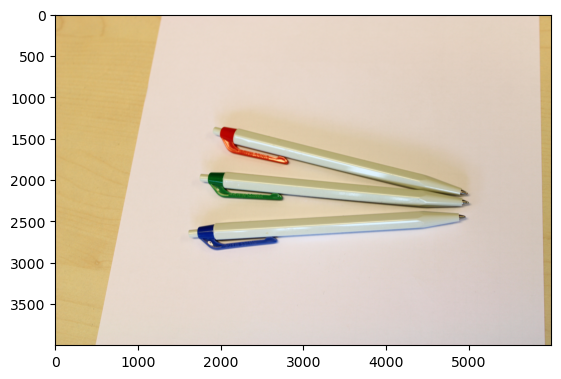

In [3]:
plt.imshow(im)

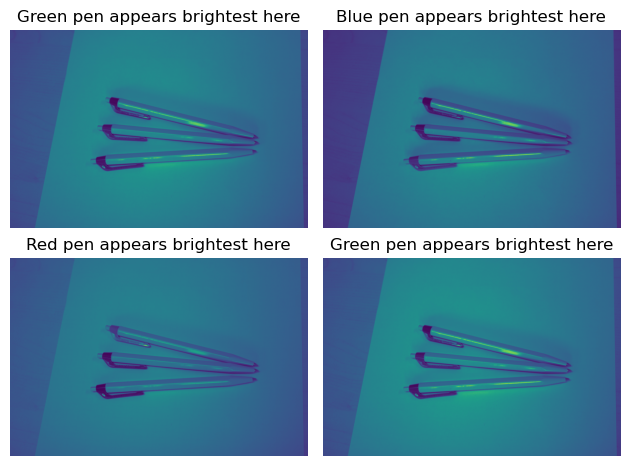

In [4]:
p00 = raw_img[0::2, 0::2]  # row even,  col even
p01 = raw_img[0::2, 1::2]  # row even,  col odd
p10 = raw_img[1::2, 0::2]  # row odd,   col even
p11 = raw_img[1::2, 1::2]  # row odd,   col odd


fig, axs = plt.subplots(2, 2)

# Plot the four channels
# green pen is the brightest, so green values should be higher
# meaning this is the green channel
axs[0,0].imshow(p00)
axs[0,0].axis('off')
axs[0,0].set_title('Green pen appears brightest here')

# blue pen is the brightest in the second plot
axs[0,1].imshow(p01)
axs[0,1].axis('off')
axs[0,1].set_title('Blue pen appears brightest here')

# red pen is the brightest in the third plot
axs[1,0].imshow(p10)
axs[1,0].axis('off')
axs[1,0].set_title('Red pen appears brightest here')

# green pen is the brightest in the fourth plot
axs[1,1].imshow(p11)
axs[1,1].axis('off')
axs[1,1].set_title('Green pen appears brightest here')

plt.tight_layout()
plt.show()

So the bayer pattern is GBRG

#### Task 2: Demosaicing Algorithm

In [5]:
def create_mask(dims):
    """ 
    Create R, G, B masks based on image dims. Assumes RGGB pattern.
    """
    h, w = dims
    R = np.zeros((h,w), dtype=np.float32)
    G = np.zeros((h,w), dtype=np.float32)
    B = np.zeros((h,w), dtype=np.float32)

    # green mask
    G[0::2, 1::2] = 1.0 
    G[1::2, 0::2] = 1.0  
    # red mask
    R[0::2, 0::2] = 1.0  
    # blue mask
    B[1::2, 1::2] = 1.0 
    return R, G, B

def demosaic(raw_img, kernel_size = (3,3)):
    """
    Returns a demosaiced RGB image
    """
    data_f = raw_img.astype(np.float32)
    kernel = np.ones(kernel_size, dtype=np.float32)
    r_mask, g_mask, b_mask = create_mask(raw_img.shape)

    R = ndi.convolve(data_f * r_mask, kernel, mode='reflect') / ndi.convolve(r_mask, kernel, mode='reflect')
    G = ndi.convolve(data_f * g_mask, kernel, mode='reflect') / ndi.convolve(g_mask, kernel, mode='reflect')
    B = ndi.convolve(data_f * b_mask, kernel, mode='reflect') / ndi.convolve(b_mask, kernel, mode='reflect')
    
    return np.stack((R, G, B), axis=-1)

def norm_img(img, only_image=False):
    """ Normalize image for visualization """
    a = np.percentile(img, 0.01)
    b = np.percentile(img, 99.99)
    norm_image = (img - a)/ (b-a)
    norm_image[norm_image<0] = 0
    norm_image[norm_image>1] = 1

    if only_image:
        return norm_image.astype(np.float32)

    return norm_image.astype(np.float32), a, b

def denorm(normed, a, b):
    """ Denormalize image from [0,1] to [a,b] """
    return normed * (b - a) + a

def visualize_image(img, title="Image"):
    """ Visualize image"""
    plt.figure()
    plt.title(title)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def load_raw(path):
    """ Load CR3 file and return raw image as np array and rawpy object """
    raw = rawpy.imread(path)
    array = np.array(raw.raw_image_visible)
    return array, raw

In [6]:
# load the CR3 file
p = ("exercise_2_data/02/IMG_4782.CR3")
raw_img, raw = load_raw(p)

# check shape and dtype
raw_img.shape, raw_img.dtype

((4660, 6984), dtype('uint16'))

In [7]:
# R - 0 G - 1 B - 2 G - 3
raw.color_desc, raw.raw_pattern     # shows the smallest bayer pattern  

(b'RGBG',
 array([[0, 1],
        [3, 2]], dtype=uint8))

So the bayer pattern is RGGB

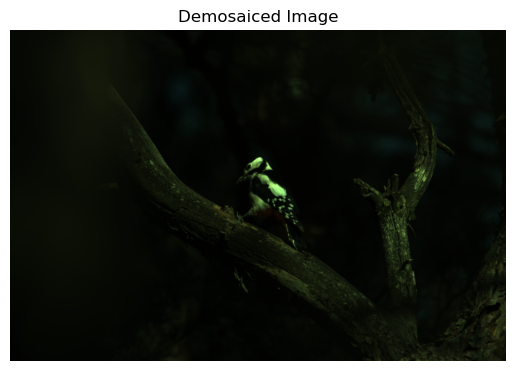

In [8]:
# demosaic the raw image
rgb = demosaic(raw_img)
# visualize normalized demosaiced image
normed_rgb, a, b = norm_img(rgb)
visualize_image(normed_rgb, title="Demosaiced Image")
plt.imsave("task2.png", normed_rgb)

#### Task 3:  Improve the Luminosity

Text(0.5, 1.0, 'Delta Equation Image')

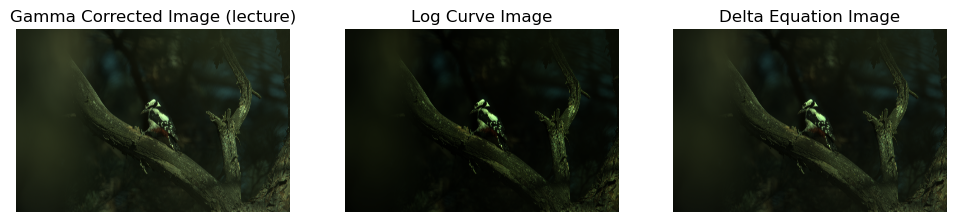

In [9]:
def lecture_gamma(normed_img, gamma = 0.3):
    """
    y = x^gamma where higher gamma = darker image
    """
    return normed_img ** gamma

 
def lecture_log(normed_img, gamma = 0.3):

    return norm_img(gamma * np.log1p(normed_img), only_image=True)

def delta_eqn(normed_img, delta=0.7):
    """
    y = (x^delta) + (x*delta)
    """
    y = (normed_img ** delta) + (normed_img * delta) + 1
    return norm_img(y, only_image=True)

gamma_corrected = lecture_gamma(normed_rgb, gamma=0.6)
# visualize_image(gamma_corrected, title="Gamma Corrected Image (lecture)")
log_corrected = lecture_log(normed_rgb, gamma=2.2)
# visualize_image(log_corrected, title="Log Curve Image")

delta_corrected = delta_eqn(normed_rgb, delta=0.6)
# visualize_image(delta_corrected, title="Delta Equation Image")

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(gamma_corrected)
ax[0].axis('off')
ax[0].set_title("Gamma Corrected Image (lecture)")
ax[1].imshow(log_corrected)
ax[1].axis('off')
ax[1].set_title("Log Curve Image")
ax[2].imshow(delta_corrected)
ax[2].axis('off')
ax[2].set_title("Delta Equation Image")

In [10]:
# inverted back to original scale
denorm_gamma = denorm(gamma_corrected, a, b)
denorm_log = denorm(log_corrected, a, b)

In [11]:
# checking if denormalization worked
denorm_gamma.min(), denorm_gamma.max(), gamma_corrected.min(), gamma_corrected.max()

(np.float32(2071.0), np.float32(14732.4), np.float32(0.0), np.float32(1.0))

#### Task 4: White balance

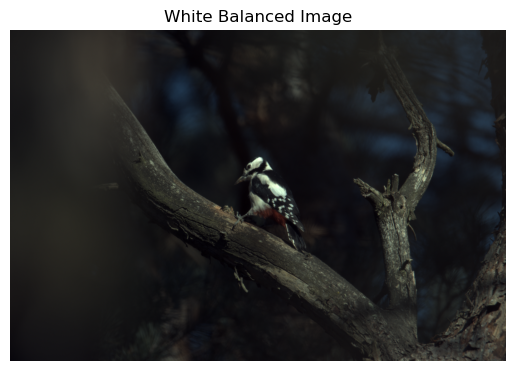

In [12]:
def gray_world(image):
    """ Applies gray world for white balancing"""
    i_mean = np.mean(image)
    red_mean = np.mean(image[:,:,0])
    green_mean = np.mean(image[:,:,1])
    blue_mean = np.mean(image[:,:,2])

    scaled_r = image[:,:,0] * i_mean / red_mean
    scaled_g = image[:,:,1] * i_mean / green_mean
    scaled_b = image[:,:,2] * i_mean / blue_mean

    return np.stack((scaled_r, scaled_g, scaled_b), axis=-1)


# white balancing on gamma corrected denorm image
white_balanced = gray_world(denorm_gamma)
visualize_image(norm_img(white_balanced, only_image=True), title="White Balanced Image")     # norm before visualization


#### Task 5: Show that Sensor Data is Linear

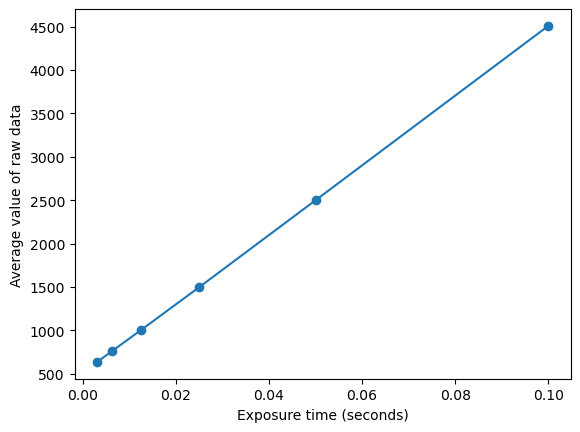

In [13]:
# path to image folder
folder = Path("exercise_2_data/05/")
# the given exposure times
exp_time = np.array([1/10, 1/20, 1/40, 1/80, 1/160, 1/320], dtype=np.float32)
means = []

def calculate_pixel_mean(im):
    """ Calcuate the pixel mean of the entire image """   
    return np.mean(im.astype(np.float32))

# grab only CR3 files and compute mean raw pixel value
for im_path in folder.glob("*CR3"):
    try:
        raw_img, raw = load_raw(str(im_path))
        means.append(calculate_pixel_mean(raw_img))
    except Exception as e:
        print(f"Error processing {im_path}: {e}")

# plot exposure vs mean
plt.plot(exp_time, means, 'o-')
plt.xlabel("Exposure time (seconds)")
plt.ylabel("Average value of raw data")
plt.show()

#### Task 6: Initial HDR Implementation

In [14]:
folder = Path("exercise_2_data/06/")
sorted_files = sorted(folder.glob("*CR3"))

# 00.CR3 is the brightest image = longest exposure
# the rest of the images reduce in brightness gradually = lower exposure times
# exposure time reduces by half for each image
exp_time = np.array([1.0/(2**i) for i in range(len(sorted_files))])

# list of tuples with image path and exposure time
data = list(zip(sorted_files, exp_time))

In [15]:
def HDR(data):
    h_img, h_raw = load_raw(str(data[0][0]))
    h_img = h_img.astype(np.float32)
    max_exp = data[0][1]    # first image has max exposure
    
    # iterate over the rest of the images
    for im_path, curr_exp in data[1:]:
        i_img, raw = load_raw(str(im_path))
        i_img = i_img.astype(np.float32)
        exp_change = max_exp / curr_exp

        i_scaled = i_img * exp_change
        thresh = 0.8 * np.max(h_img)

        # replace pixels in h that are too birght with the ones in 
        # scaled i
        mask = h_img >= thresh
        h_img[mask] = i_scaled[mask]
        
    return h_img.astype(np.float32)

def log_norm(image):
    """ Apply logarithmic normalization to the image """
    # Apply logarithm (add 1 to avoid log(0))
    im_log = np.log(image + 1)
    log_min = np.min(im_log)
    log_max = np.max(im_log)
    # Normalize to [0, 255] range
    im_log_norm = (im_log - log_min) / (log_max - log_min) * 255

    return im_log_norm.astype(np.uint8)


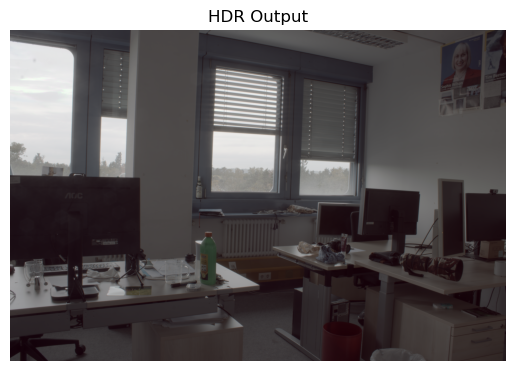

In [16]:
hdr_image = HDR(data)

# apply demosaic and gray world white balancing
clean_hdr_image = gray_world(demosaic((hdr_image)))

# log norm
log_norm_image = log_norm(clean_hdr_image)

# Visualize the images
visualize_image(log_norm_image, title="HDR Output")

# uncomment to save the image
# plt.imsave('hdr_out.jpg', log_norm_image)

#### Task 7: Implement iCAM06

In [17]:
def iCAM06(hdr_im):

    hdr_im = hdr_im.astype(np.float32, copy=False)
    out_range = 7
    eps = 1e-8

    inp_intensity = 1/61 * (20 * hdr_im[:,:,0] + 40 * hdr_im[:,:,1] + 1 * hdr_im[:,:,2])
    inp_intensity = np.maximum(inp_intensity, eps)      # to avoid division by zero
    r,g,b = hdr_im[:,:,0] / inp_intensity, hdr_im[:,:,1] / inp_intensity, hdr_im[:,:,2] / inp_intensity

    log_inp_intensity = np.log(inp_intensity).astype(np.float32)
    # d = window size 
    log_base = cv2.bilateralFilter(log_inp_intensity, d=5, sigmaColor = .3, sigmaSpace=.4)
    log_detail = log_inp_intensity - log_base

    compression = np.log(out_range) / (np.max(log_base) - np.min(log_base))

    log_offset = -np.max(log_base) * compression

    out_intensity = np.exp( log_base * compression + log_offset + log_detail)

    r, g, b = r * out_intensity, g * out_intensity, b * out_intensity

    out_icam = np.stack((r, g, b), axis=-1)

    return out_icam

    
    

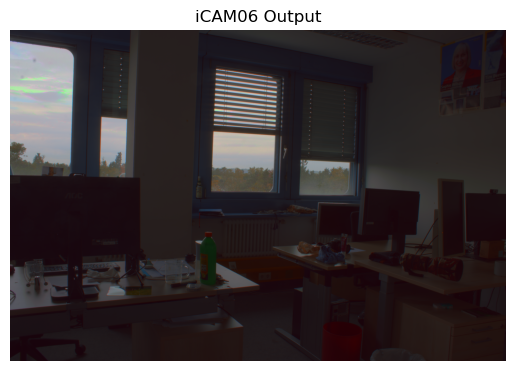

In [18]:
icam_image = iCAM06(clean_hdr_image)

# visualize the iCAM06 output
visualize_image(norm_img(icam_image, only_image=True), title="iCAM06 Output")


#### Task 8: Win

In [19]:
def process_raw(in_path, out_path = None):
    try:
        # load image
        raw_img, raw = load_raw(in_path)
        # demosaicing
        dem_img = demosaic(raw_img)
        # normalize for gamma correction
        normed_dem, a, b = norm_img(dem_img)
        # gamma correction
        gamma_img = lecture_gamma(normed_dem, gamma=.7)
        # invert back to original scale
        den = denorm(gamma_img, a, b)
        # whitebalancing
        wb = gray_world(den)
        # tone mapping
        tone_mapped = iCAM06(wb)
        # normalization for visualization
        normed_out = norm_img(tone_mapped, only_image=True)
       
        # make sure saving is high quality
        if out_path is not None:
            # Convert float32 [0,1] to uint8 [0,255] for JPG saving
            img_uint8 = (normed_out * 255).astype(np.uint8)
            Image.fromarray(img_uint8, mode='RGB').save(
                out_path,
                format='JPEG',
                quality=95,
                optimize=True
            )
        
        return normed_out
        
    except Exception as e:
        print(f"Error processing {in_path}: {e}")
        return None



In [20]:
out = process_raw("exercise_2_data/02/IMG_4782.CR3", "task8_win.jpg")